# Тестирование алгоритма Вигдерсона

In [1]:
import numpy as np
from scipy.stats import bernoulli, uniform, randint
import matplotlib.pyplot as plt
import networkx
import tqdm
import itertools
%matplotlib inline

plt.rc('font', size="16")

from WigdersonAlgorithm import get_coloring

## Вспомогательные функции и генерация графов


Проверка сертификата раскраски

In [2]:
def is_legal_coloring(graph, colors):
    for v in range(len(graph)):
        for u in graph[v]:
            if colors[v] == -1 or colors[u] == -1:
                continue
            if colors[v] == colors[u]:
                print(u, v)
                return False

    return True

Генерируется $k$-дольный случайный граф с заданной вероятностью ребра, $k \in \{2, 3\}$

Цвета вершин соответствуют номерам блоков по номерам: $[0..\frac{n}{2}), [\frac{n}{3} .. 2 \cdot \frac{n}{3}), [2 \cdot \frac{n}{3} .. n)$ 

In [3]:
def get_k_coloring_sample(sizes=[333, 333, 333], p=0.5):
    graph = [[] for i in range(sum(sizes))]
    
    starts = [0] + list(np.cumsum(sizes))
    
    for i, j in itertools.combinations(range(3), 2):
        for u in range(starts[i], starts[i + 1]):
            for v in range(starts[j], starts[j + 1]):
                if bernoulli.rvs(p):
                    graph[u].append(v)
                    graph[v].append(u)
    return graph

Генерируется тест, на котором достигается максимальная раскраска

In [4]:
def get_maximal_test_sample(sqrt_n=32):
    k = sqrt_n
    n = k ** 2
    
    graph = [[] for i in range(n)]
    
    for i in range(k - 1):
        start = i * (k + 1)
        for v in range(k + 1):
            graph[v + start].append((v + 1) % (k + 1) + start)
            graph[(v + 1) % (k + 1) + start].append(v + start)
        
        for v in range(2, k):
            graph[start].append(v + start)
            graph[v + start].append(start)
    
    return graph

Создает граф для бибилиотека networkx

In [5]:
def mk_networkx_graph(graph):
    G = networkx.DiGraph()
    for i in range(len(graph)):
        G.add_node(i)
    for v in range(len(graph)):
        for u in graph[v]:
            G.add_edge(v, u)
    return G


Рисует граф

In [6]:
def draw_graph(G, colors=0, pos=None):
    colors = np.array(colors, dtype=float)
    plt.axis('off')
    networkx.draw_networkx(G, node_color=colors / max(colors), pos=pos)

Генерирует случайный граф и показывает оптимальную раскраску и жадную

In [21]:
def test_and_color(sizes = [7, 7, 7]):
    starts = np.cumsum(sizes)
    graph = get_k_coloring_sample(sizes)
    colors = get_coloring(graph)
    num_colors = max(colors) + 1
    G = mk_networkx_graph(graph)
    pos = networkx.layout.shell_layout(G)
#     pos = networkx.layout.shell_layout(G,
#                                        nlist=[
#                                            range(starts[0]),
#                                            range(starts[0], starts[1]),
#                                            range(starts[1], starts[2])])
    plt.figure(figsize=(20, 10))
    plt.subplot(1,2,1)
    plt.title("n = {}\n раскраска алгоритмом Виндерсона; цветов: {}".format(sum(sizes), num_colors))
    draw_graph(G, colors, pos)
    plt.subplot(1,2,2)
    plt.title("Трехцветная раскраска")
    draw_graph(G, [0] * sizes[0] + [1] * sizes[1] + [2] * sizes[2], pos)
    if not is_legal_coloring(graph, colors):
        print("illegal coloring")

## Примеры раскрасок

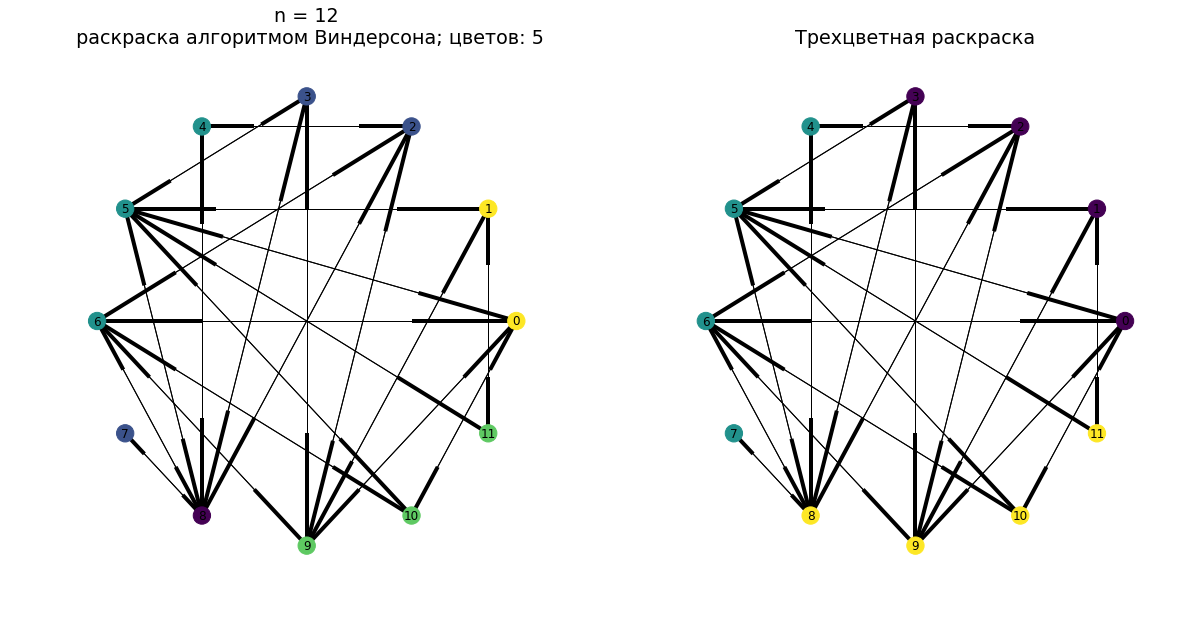

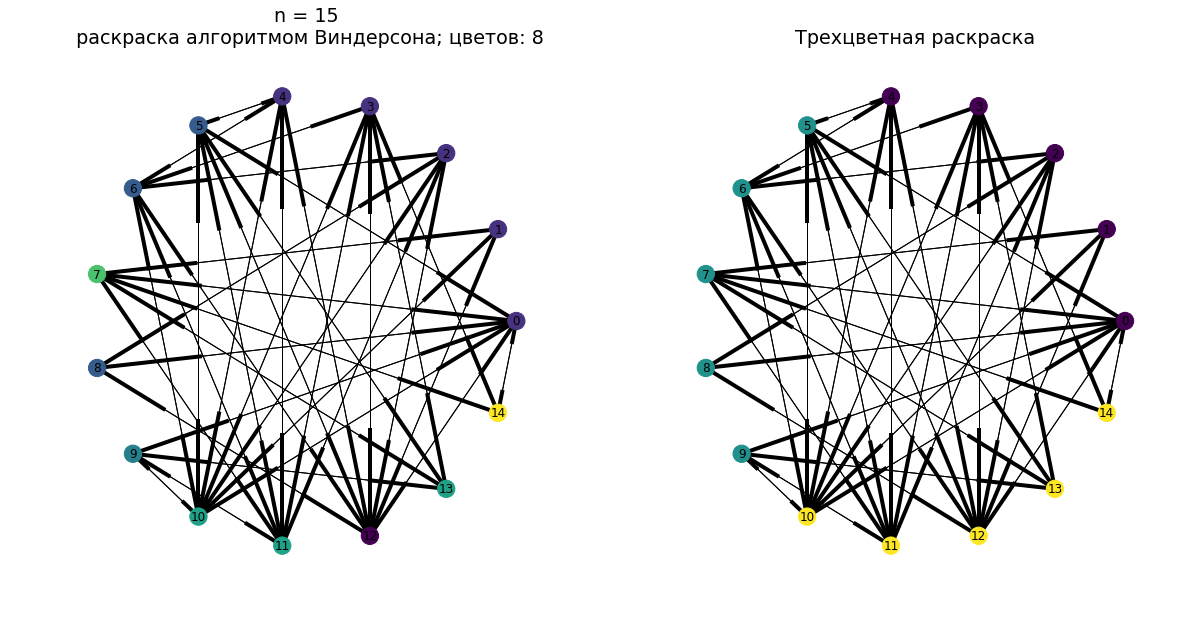

In [22]:
test_and_color([4, 4, 4])
test_and_color([5, 5, 5])

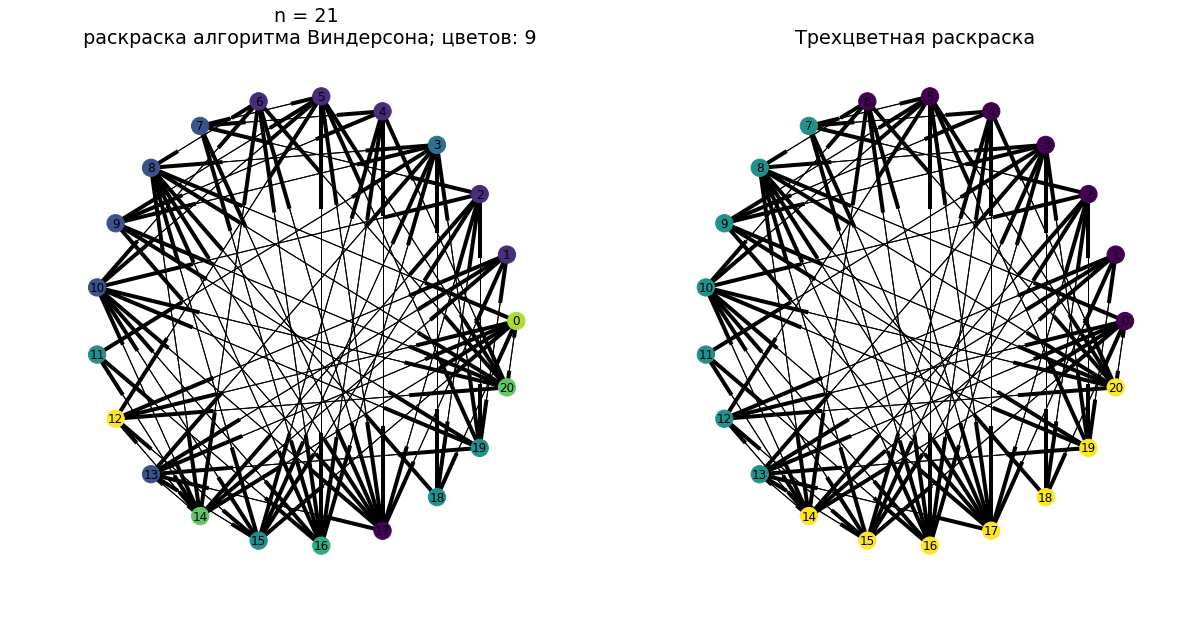

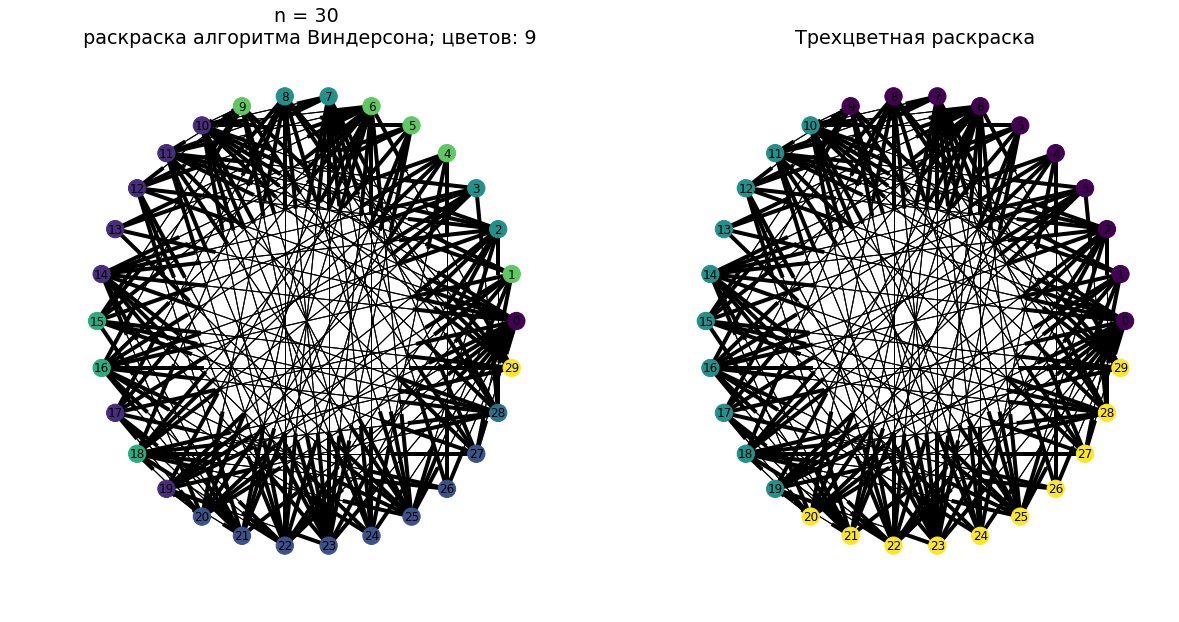

In [20]:
test_and_color([7, 7, 7])
test_and_color([10, 10, 10])

## Стресс-тест

In [10]:
def stress_test(iters=20, maxn=10**2):
    for i in tqdm.tqdm_notebook(range(iters)):
        n = randint.rvs(max(1, maxn // 2), maxn)
        p = uniform.rvs()
        graph = get_k_coloring_sample([n, n, n], p)
        colors = get_coloring(graph)
        if is_legal_coloring(graph, colors):
            print("test {} is ok (n = {}, p = {:.2f})".format(i, n * 3, p))
        else:
            raise ValueError("incorrect coloring")

In [11]:
stress_test(20, 100)
stress_test(1, 2)

test 0 is ok (n = 264, p = 0.15)
test 1 is ok (n = 189, p = 0.17)
test 2 is ok (n = 258, p = 0.92)
test 3 is ok (n = 294, p = 0.19)
test 4 is ok (n = 165, p = 0.40)
test 5 is ok (n = 264, p = 0.17)
test 6 is ok (n = 231, p = 0.52)
test 7 is ok (n = 216, p = 0.09)
test 8 is ok (n = 171, p = 0.50)
test 9 is ok (n = 159, p = 0.61)
test 10 is ok (n = 189, p = 0.93)
test 11 is ok (n = 195, p = 0.21)
test 12 is ok (n = 261, p = 0.39)
test 13 is ok (n = 237, p = 0.79)
test 14 is ok (n = 234, p = 0.63)
test 15 is ok (n = 213, p = 0.29)
test 16 is ok (n = 285, p = 0.32)
test 17 is ok (n = 231, p = 0.58)
test 18 is ok (n = 279, p = 0.40)
test 19 is ok (n = 150, p = 0.56)



test 0 is ok (n = 3, p = 0.99)



## Проверка асимптотики количества цветов.
Из алгоритма их должно быть не больше $4 \cdot \sqrt{n}$.

### Максимальный тест
Построим пример, на котором алгоритм будет достигать оценки в $\sqrt{n}$. Из описания алгоритма следует, что больше всего цветов прибавляется на первых двух стадиях (раскрашивании вершин с большой степенью с соседями). То есть можно сделать $\sqrt{n} - 1$ несвязных кластеров с циклом из $\sqrt{n} + 1$ вершин, одна из которых соединена со всеми другими. Оставшуюся вершину ни с чем не соединять.

Тогда реализованный алгоритм должен последовательно закрашивать кластеры, что даст порядка $3 \cdot \sqrt{n}$ цветов.

In [12]:
ns = []
nums = []

for k in range(4, 33):
    graph = get_maximal_test_sample(k)
    colors = wigderson_algorithm(graph)
#     print(colors)
    num = max(colors) - min(colors) + 1
    if not is_legal_coloring(graph, colors):
        raise ValueError("incorrect coloring")
    nums.append(num)
    ns.append(k ** 2)

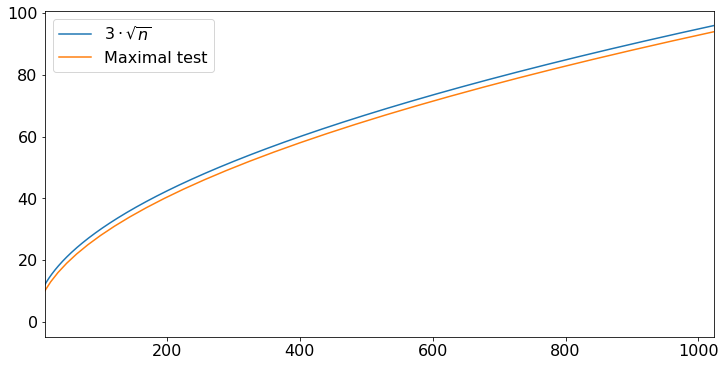

In [13]:
plt.figure(figsize=(12, 6))
asym = lambda x : 3 * np.sqrt(x)
grid = np.linspace(0, 1024, 1000)
plt.plot(grid, asym(grid), label=r'$3 \cdot \sqrt{n}$')
plt.plot(ns, nums, label='Maximal test')
plt.legend(loc='upper left')
plt.xlim(16, 1024)
plt.show()

### Случайные графы
Теперь проведем тестирование на случайных графах

In [14]:
maxn = 200
ns = np.arange(2, maxn, 20)

def test_fix_prob(p=0.5, alg=get_coloring):
    num_colors = []
    for n in tqdm.tqdm(ns):
        graph = get_k_coloring_sample([n, n, n], p)
        colors = alg(graph)
        num_colors.append(max(colors) + 1)
    return num_colors

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


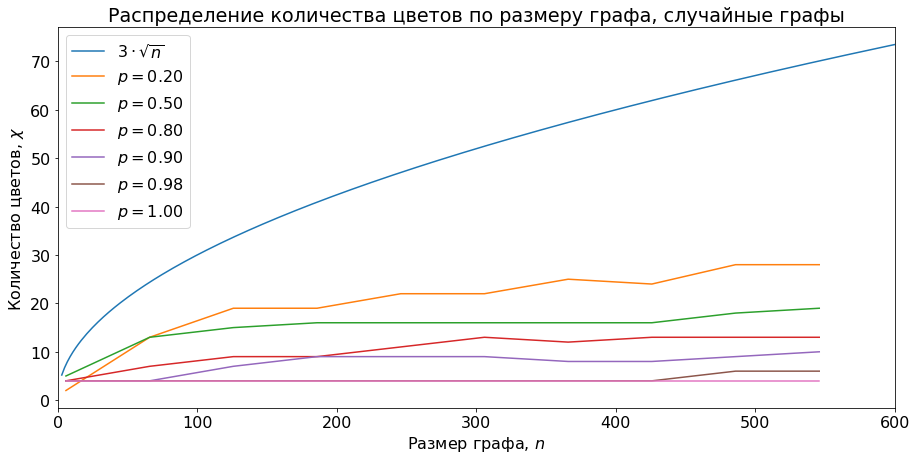

In [15]:
plt.figure(figsize=(15, 7))
grid = np.linspace(1, maxn, 300) * 3
plt.plot(grid, asym(grid), label='$3 \cdot \sqrt{n}$')
plt.title("Распределение количества цветов по размеру графа, случайные графы")
plt.xlabel("Размер графа, $n$")
plt.ylabel("Количество цветов, $\chi$")
for p in [0.2, 0.5, 0.8, 0.9, 0.98, 1]:
    plt.plot(ns * 3, test_fix_prob(p), label='$p = {:.2f}$'.format(p))
plt.legend(loc='upper left')
plt.xlim(0, maxn * 3)
plt.show()

При увеличении $p$ количество цветов уменьшается.

На этот эффект влияет то, что граф становится более структуризированным: становится похожим на $K_{(n, n, n)}$. Тогда алгоритм на первом шаге красит соседей (а это почти все вершины из других компонент) в два цвета. А потом  на оставшемся маленьком количестве вершин жадный алгоритм завершает работу, покрасив все в три цвета.


## Распределение количества цветов по вероятностям

In [16]:
maxn = 100

pgrid = np.linspace(0, 1, 20)
num_colors = []
for p in tqdm.tqdm(pgrid):
    colors_sum = 0
    for n in range(2, maxn, 10):
        graph = get_k_coloring_sample([n, n, n], p)
        colors = get_coloring(graph)
        colors_sum += max(colors) + 1
    num_colors.append(colors_sum / (maxn - 2))

100%|██████████| 20/20 [01:05<00:00,  3.26s/it]


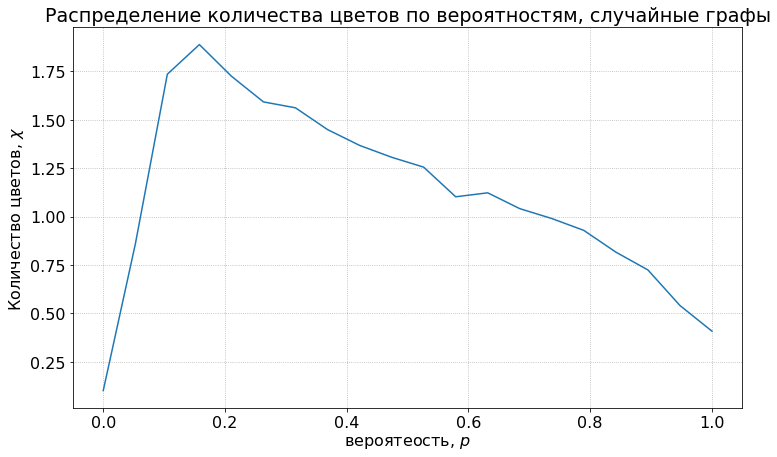

argmax num_colors(p) = 0.158


In [17]:
plt.figure(figsize=(12, 7))
plt.plot(pgrid, num_colors)
plt.title("Распределение количества цветов по вероятностям, случайные графы")
plt.xlabel("вероятеость, $p$")
plt.ylabel("Количество цветов, $\chi$")
plt.grid(ls=":")
plt.show()
print("argmax num_colors(p) = {:.3f}".format(pgrid[np.argmax(num_colors)]))

При $p = 0.158$ алгоритм в среднем использует наибольшее число цветов. 
При малом p степени вершин маленькие и работать будет, в основном, жадный алгоритм, а количество цветов будет близко к $O(\sqrt{n})$. При росте $p$ степени вершин растут и становится оправданным использование алгоритма Вигдерсона.

## Выводы
1. Написали Алгритм Вигдерсона
2. Нарисовали маленькие тесты
3. Протестировали на случайных графах
4. Построили максимальный тест
5. Посмотрели на распределение количества цветов по количеству вершин и по вероятностям